# Task 1

Обнаружение разметки полосы движения

В этом задании вы реализуете детектор разметки полосы движения (lane line detector). Обнаружение разметки играет ключевую роль в системах ADAS (Advanced Driver Assistance Systems — продвинутые системы помощи водителю), в частности, в системах LKA (Lane Keep Assist — помощь в удержании полосы).

Вам будет предоставлена фотография с фронтальной камеры автомобиля. Необходимо выполнить следующие шаги:

Преобразовать изображение в оттенки серого.
Вычислить карту границ (edge map).
Применить преобразование Хафа для получения параметрического представления прямых линий.

## Шаг 1: Импорт необходимых библиотек

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

## Шаг 2: Загрузка и отображение исходного изображения

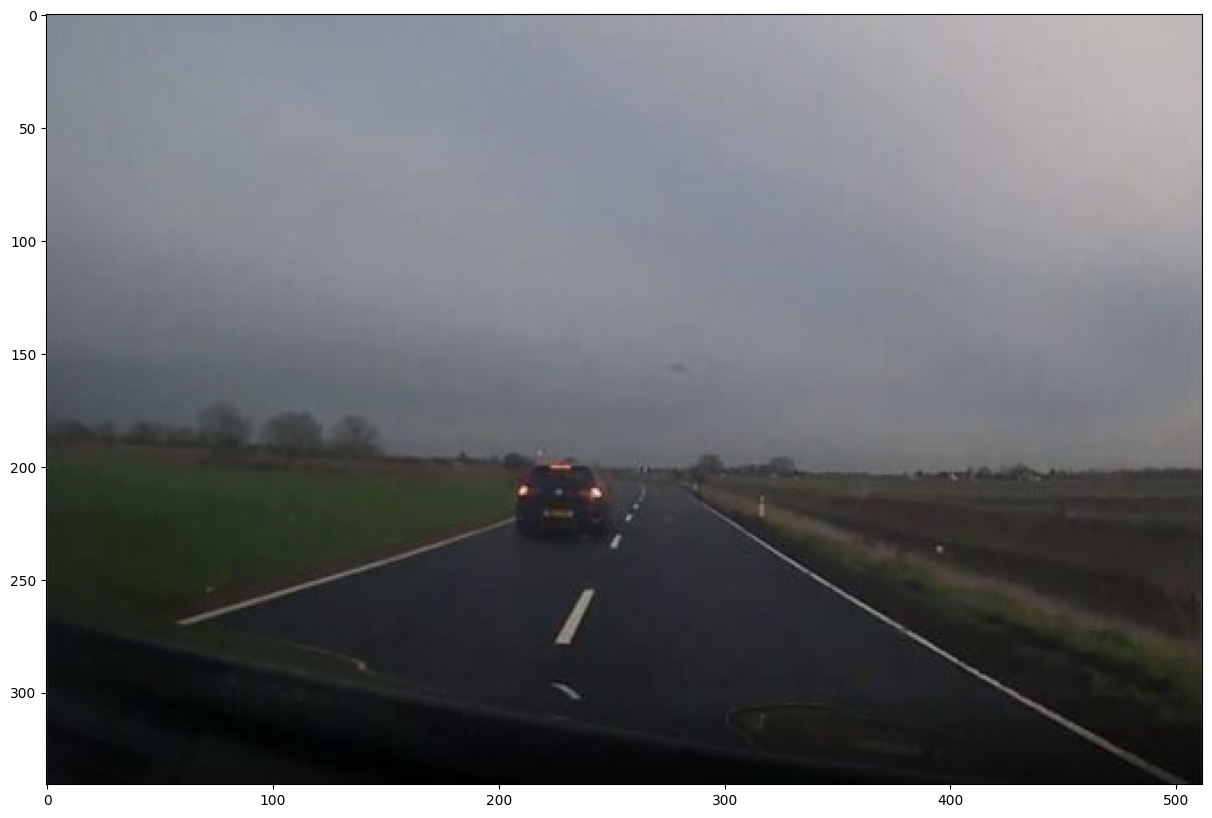

In [ ]:
project_dir = ''

img = cv2.imread(f'{project_dir}/data/dashcam.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

## Шаг 3: Преобразование в оттенки серого

In [ ]:
# Преобразуем цветное изображение в градации серого
gray = ########

## Шаг 4: Построение карты границ с помощью детектора Кэнни

In [ ]:
# Применяем детектор границ Кэнни
# Пороги: нижний = 100, верхний = 150 (рекомендованные значения)
edges = ####

## Шаг 5: Визуализация исходного изображения и карты границ

(<Axes: title={'center': 'Edge map'}>,
 Text(0.5, 1.0, 'Edge map'))

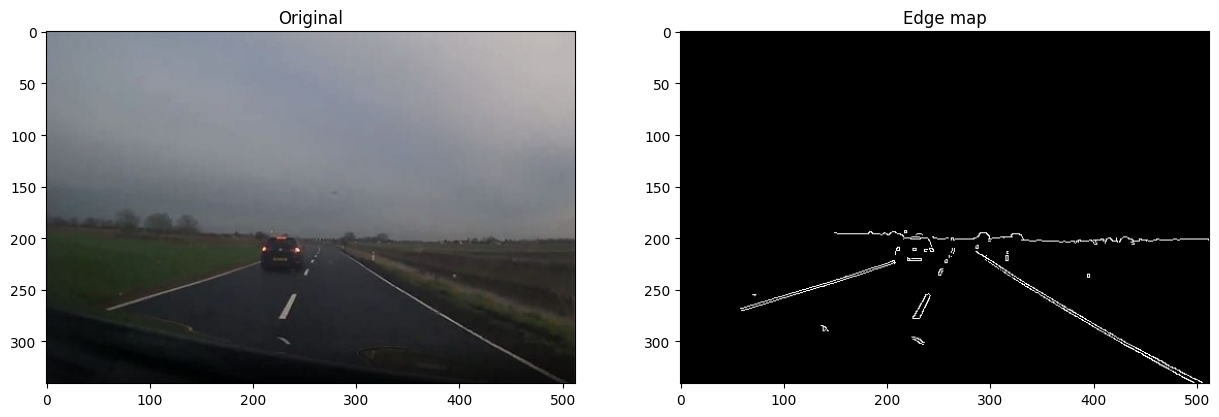

In [5]:
# Let's plot the images
plt.subplot(121), plt.imshow(img), plt.title('Original')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edge map')

## Шаг 6: Применение преобразования Хафа для обнаружения прямых

In [ ]:
# Применяем стандартное преобразование Хафа для обнаружения прямых
# Параметры:
#   rho — разрешение по расстоянию (в пикселях): 5
#   theta — разрешение по углу (в радианах): 5 градусов = 5 * π / 180
#   threshold — порог аккумулятора: 90 (минимальное число голосов для признания линии)

lines = ####

# Убираем лишнее измерение (OpenCV возвращает массив формы [N, 1, 2])
lines = lines[:, 0, :]

## Шаг 7: Отображение всех найденных линий Хафа

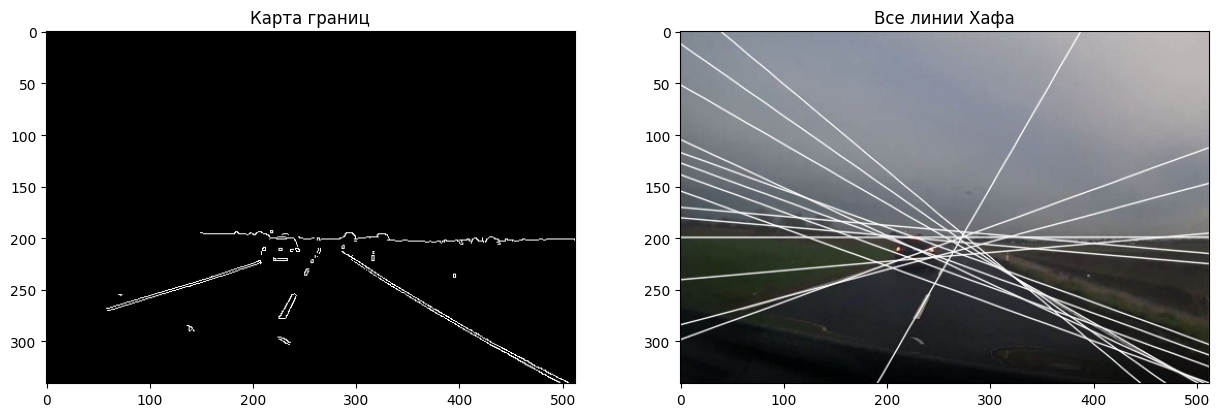

In [ ]:
# Копируем исходное изображение для наложения линий
result = np.copy(img)

# Проходим по всем найденным линиям
for line in lines:
    rho =       # Расстояние от начала координат до прямой
    theta =     # Угол нормали к прямой (в радианах)

    # Вычисляем направляющий вектор прямой
    a = math.cos(theta)
    b = math.sin(theta)

    # Точка (x0, y0) — ближайшая к началу координат точка на прямой
    x0 = a * rho
    y0 = b * rho

    # Строим две точки на прямой, далеко друг от друга (для отрисовки всей линии)
    pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
    pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))

    # Рисуем линию на изображении белым цветом (255 в RGB — белый)
    cv2.line(result, pt1, pt2, (255, 255, 255), thickness=1, lineType=cv2.LINE_AA)

# Визуализация
plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Карта границ')
plt.subplot(122), plt.imshow(result), plt.title('Все линии Хафа')
plt.show()

Примечание: На этом этапе видно много "шумных" линий, включая горизонтальные (например, от горизонта или разметки на дороге, не относящейся к полосам). 

## Шаг 8: Фильтрация горизонтальных линий
Горизонтальные линии не могут быть разметкой полосы — они соответствуют углу θ ≈ 90° (π/2 радиан). Удалим все линии, у которых угол отклоняется от вертикали менее чем на 15° от горизонтали.

In [ ]:
# Создаём список для отфильтрованных линий
filtered_lines = []

for line in lines:
    theta = line[1]  # угол в радианах

    # Переводим угол в градусы для удобства
    theta_deg = #######

    # Горизонтальные линии: около 90° или 270° (но theta ∈ [0, π), т.е. [0°, 180°))
    # Поэтому горизонталь — это theta ≈ 90° ± 15° → [75°, 105°]
    if ....
        filtered_lines.append(line)

# Преобразуем в массив NumPy для удобства
filtered_lines = np.array(filtered_lines)

## Шаг 9: Отображение отфильтрованных линий

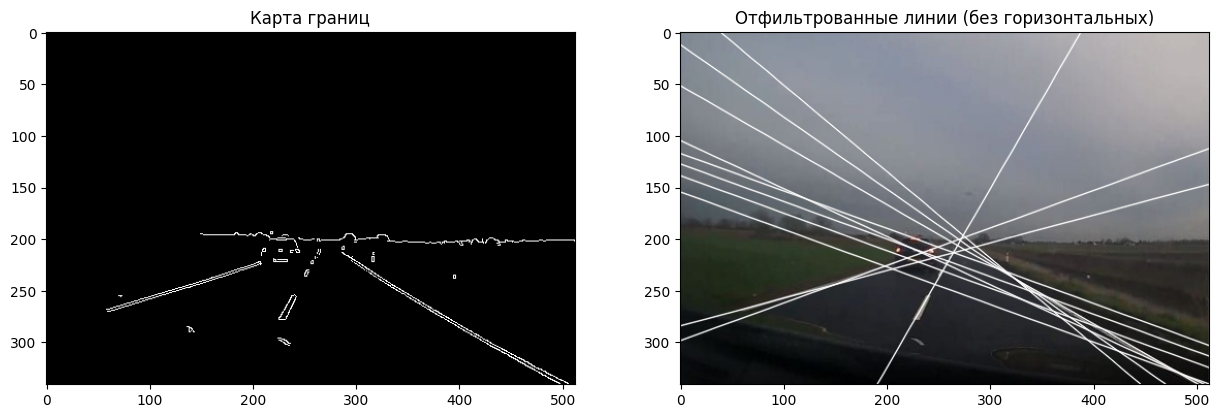

In [ ]:
result = np.copy(img)

for line in filtered_lines:
    rho =  
    theta =  

    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho

    pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
    pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))

    cv2.line(result, pt1, pt2, (255, 255, 255), thickness=1, lineType=cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Карта границ')
plt.subplot(122), plt.imshow(result), plt.title('Отфильтрованные линии (без горизонтальных)')
plt.show()

Рзультат: Уже лучше — горизонтальные линии удалены, но остаются дублирующие линии (несколько близких линий для одной и той же разметки). 

## Шаг 10: Кластеризация с помощью K-means для устранения дубликатов
Мы ожидаем увидеть три основные линии: левая граница левой полосы, правая граница правой полосы и, возможно, центральная разметка или тень. Применим K-means к параметрам (ρ, θ), чтобы сгруппировать близкие линии и взять центры кластеров как итоговые линии.

In [10]:
from sklearn.cluster import KMeans

# Применяем K-means с 3 кластерами
kmeans = KMeans(n_clusters=3, random_state=42).fit(filtered_lines)

# Центры кластеров — усреднённые параметры линий
refined_lines = kmeans.cluster_centers_

## Шаг 11: Отображение итоговых линий после кластеризации

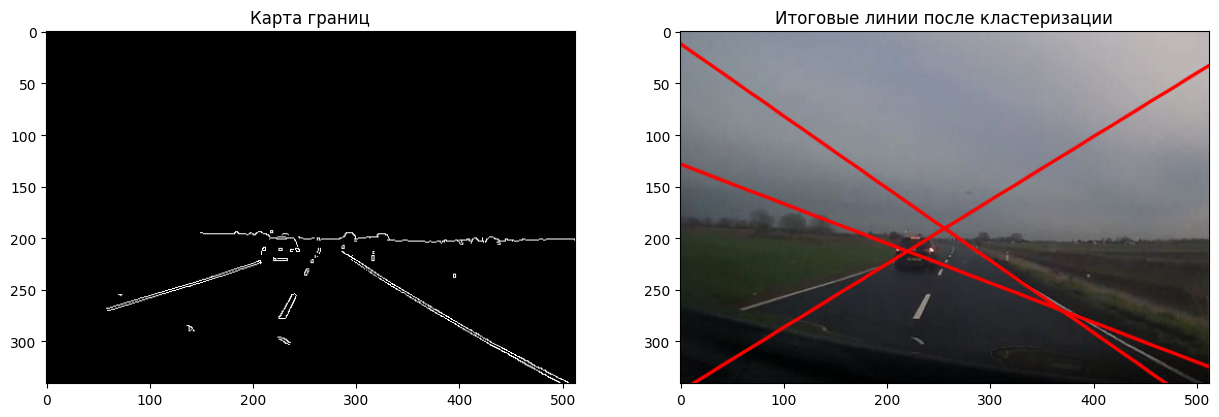

In [ ]:
result = np.copy(img)

for line in refined_lines:
    rho =  
    theta =  

    .....

    pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
    pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))

    # Рисуем линию красным цветом для наглядности
    cv2.line(result, pt1, pt2, (255, 0, 0), thickness=2, lineType=cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Карта границ')
plt.subplot(122), plt.imshow(result), plt.title('Итоговые линии после кластеризации')
plt.show()

### Ответы на контрольные вопросы
1. Что кажется странным в итоговом результате?


2. Важно ли разрешение преобразования Хафа для получения хорошего результата? Почему?


3. Важен ли порог аккумулятора (threshold) в преобразовании Хафа? Почему?

